Download and crop images

In [ ]:
# Provided by ChatGPT
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import os

def download_image(url):
    try:
        response = requests.get(url)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except requests.exceptions.RequestException as e:
        print(f"Failed to download {url}: {e}")
        return None

def crop_and_save_image(image, bbox, save_path):
    width, height = image.size
    left = bbox[0] * width
    top = bbox[2] * height
    right = bbox[1] * width
    bottom = bbox[3] * height
    
    cropped_image = image.crop((left, top, right, bottom))
    cropped_image.save(save_path)

def process_csv(file_path, output_dir):
    # Read the first 10 lines of the CSV file
    df = pd.read_csv(file_path, header=None, nrows=10)
    
    # Iterate through each row in the DataFrame
    for index, row in df.iterrows():
        for i in range(0, len(row) - 5, 5):
            url = row[i]
            # Ensure the value is a string before checking if it is a valid URL
            if not isinstance(url, str) or not url.startswith("http"): 
                print(f"Skipping invalid URL: {url}")
                continue
            
            bbox = [row[i+1], row[i+2], row[i+3], row[i+4]]
            
            # Download the image
            image = download_image(url)
            if image is None:
                continue
            
            # Create output directory if it doesn't exist
            os.makedirs(output_dir, exist_ok=True)
            
            # Define save path for cropped image
            save_path = os.path.join(output_dir, f"cropped_face_{index}_{i//5}.jpg")
            
            # Crop and save the image
            crop_and_save_image(image, bbox, save_path)
            print(f"Saved cropped face to {save_path}")



if __name__ == "__main__":
    # Path to your CSV file
    csv_file_path = "./FEC_dataset/faceexp-comparison-data-train-public.csv"
    # Directory to save cropped face images
    output_directory = "cropped_faces"
    
    process_csv(csv_file_path, output_directory)

Load Grayscale image and 2D fourier transform it

In [ ]:
from PIL import Image
import PIL
import PIL.ImageOps
import numpy as np
from matplotlib import pyplot as plt

def transform_and_plot_image(path: str):
    img = Image.open(path)
    grayscale = PIL.ImageOps.grayscale(img)
    # grayscale.show()
    fourier_transformed = np.fft.fft2(grayscale)
    fourier_transformed_shifted = np.fft.fftshift(fourier_transformed)
    magnitude_spectrum = 20 * np.log(np.abs(fourier_transformed_shifted))
    
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Frequency Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return grayscale, fourier_transformed_shifted

grayscale_1, fourier_transformed_1 = transform_and_plot_image("./cropped_faces/cropped_face_6_1.jpg")
grayscale_2, fourier_transformed_2 = transform_and_plot_image("./cropped_faces/cropped_face_9_1.jpg")
grayscale_3, fourier_transformed_3 = transform_and_plot_image("./cropped_faces/cropped_face_3_1.jpg")

Low pass filter

In [ ]:
import numpy as np
import cv2
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt

def apply_low_pass_filter_and_plot(grayscale, fourier_transformed, scaling_factor=0.1):
    # Convert grayscale image to numpy array
    img_np = np.array(grayscale)
    
    # Use the provided Fourier transformed image
    dft_shifted = fourier_transformed
    
    # Get image dimensions
    rows, cols = img_np.shape
    crow, ccol = rows // 2, cols // 2  # Center of the image
    
    # Calculate sigma for Gaussian based on image size and scaling factor
    sigma = min(rows, cols) * scaling_factor
    
    # Create a Gaussian low-pass filter (mask)
    x = np.linspace(-ccol, ccol, cols)
    y = np.linspace(-crow, crow, rows)
    x, y = np.meshgrid(x, y)
    
    # Gaussian function
    gaussian_mask = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # Apply the Gaussian mask (low-pass filter)
    dft_shifted_filtered = dft_shifted * gaussian_mask
    
    # Inverse DFT to get the filtered image
    dft_inverse = np.fft.ifftshift(dft_shifted_filtered)  # Shift back the zero frequency
    img_filtered = np.fft.ifft2(dft_inverse)
    img_filtered = np.abs(img_filtered)
    
    # Plot the results
    plt.figure(figsize=(18, 6))
    
    # Original Image
    plt.subplot(141), plt.imshow(grayscale, cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - Original
    magnitude_spectrum = 20 * np.log(np.abs(dft_shifted))
    plt.subplot(142), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Original Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Frequency Spectrum (Magnitude) - After Low Pass Filter
    filtered_magnitude_spectrum = 20 * np.log(np.abs(dft_shifted_filtered) + 1)  # Add 1 to avoid log(0)
    plt.subplot(143), plt.imshow(filtered_magnitude_spectrum, cmap='gray')
    plt.title('Filtered Frequency Spectrum'), plt.xticks([]), plt.yticks([])

    # Filtered Image
    plt.subplot(144), plt.imshow(img_filtered, cmap='gray')
    plt.title(f'Filtered Image (Sigma={sigma:.2f})'), plt.xticks([]), plt.yticks([])

    plt.show()

# Apply the function to an image
apply_low_pass_filter_and_plot(grayscale_1, fourier_transformed_1, 0.10)
apply_low_pass_filter_and_plot(grayscale_2, fourier_transformed_2, 0.10)
apply_low_pass_filter_and_plot(grayscale_3, fourier_transformed_3, 0.10)

PCA of images

Original Image Shape: (10000,)
Projected Image Shape: (50,)


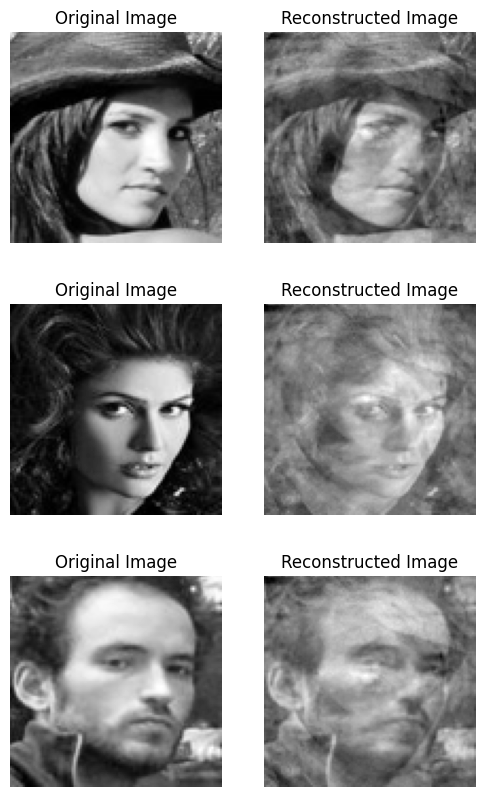

In [20]:
import numpy as np
from PIL import Image
import PIL.ImageOps
from matplotlib import pyplot as plt
import os

def preprocess_image(image_path):
    # Open image and convert to grayscale
    image = Image.open(image_path).convert('L')
    resized_image = image.resize((100, 100))

    image_array = np.array(resized_image).flatten()

    # Normalize the pixel values to the range [0, 1]
    normalized_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
    return normalized_image

def pca(images, k=10):
    # Stack the image data into a matrix (each row is an image)
    image_matrix = np.vstack(images)
    
    # Compute the covariance matrix
    covariance_matrix = np.cov(image_matrix, rowvar=False)

    # Perform eigendecomposition
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    
    # Sort the eigenvectors based on eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Select the top k eigenvectors
    top_eigenvectors = sorted_eigenvectors[:, :k]
    
    # Project the original images onto the lower-dimensional subspace defined by the selected principal components
    projected_data = np.dot(image_matrix, top_eigenvectors)

    return projected_data, top_eigenvectors

def process_and_pca_images(image_folder, k=10):
    # Load and preprocess images
    # image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('0_0.jpg') or f.endswith('0_1.jpg') or f.endswith('0_2.jpg')]
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder)]
    
    images = [preprocess_image(image_file) for image_file in image_files]
    
    # Perform PCA
    projected_images, components = pca(images, k)

    print(f"Original Image Shape: {images[0].shape}")
    print(f"Projected Image Shape: {projected_images[0].shape}")

    # Show two of the original and their reconstructed images
    plt.figure(figsize=(6, 10))
    for i in range(3):
        original_image = Image.open(image_files[i]).convert('L')
        plt.subplot(3, 2, i*2 + 1)
        plt.imshow(original_image.resize((100, 100)), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        reconstructed_image = np.dot(projected_images[i], components.T)
        plt.subplot(3, 2, i*2 + 2)
        plt.imshow(reconstructed_image.reshape(100, 100), cmap='gray')
        plt.title('Reconstructed Image')
        plt.axis('off')
    
    # return projected_images, components


# Define the path to the folder containing images
image_folder = "./cropped_faces"
process_and_pca_images(image_folder, k=10)


Test

(2, 10000)


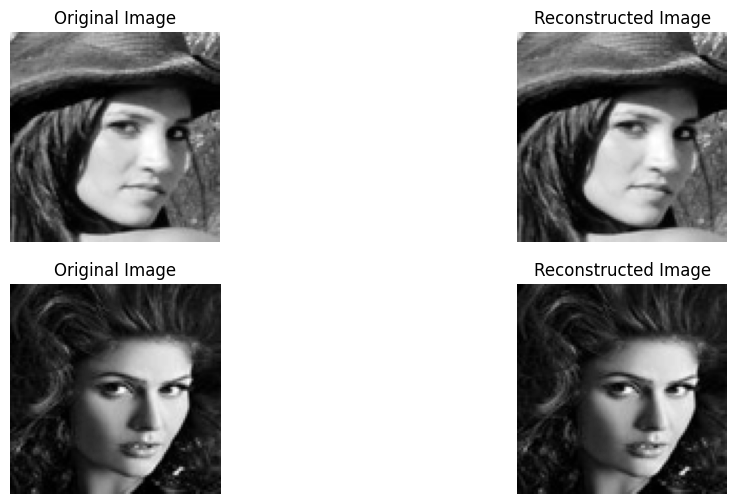

In [6]:
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os

def preprocess_image(image_path):
    # Open image and convert to grayscale
    image = Image.open(image_path).convert('L')
    image = image.resize((100, 100))  # Ensure consistent size for all images
    image_array = np.array(image).flatten()

    # Normalize the pixel values to the range [0, 1]
    normalized_image = image_array / 255.0
    return normalized_image

def compute_covariance_matrix(image_matrix):
    # Compute the covariance matrix of the image data
    # The data matrix should be of shape (num_images, num_pixels)
    mean_image = np.mean(image_matrix, axis=0)
    centered_matrix = image_matrix - mean_image
    covariance_matrix = np.cov(centered_matrix, rowvar=False)
    return covariance_matrix, centered_matrix, mean_image

def pca_manual(image_matrix, num_components=10):
    # Compute the covariance matrix
    covariance_matrix, centered_matrix, mean_image = compute_covariance_matrix(image_matrix)

    # Perform Singular Value Decomposition (SVD) instead of using np.linalg.eig
    U, S, Vt = np.linalg.svd(centered_matrix, full_matrices=False)

    # Select the top k components
    top_eigenvectors = Vt[:num_components].T
    print(Vt.shape)

    # Project the images onto the lower-dimensional subspace
    projected_data = np.dot(centered_matrix, top_eigenvectors)

    return projected_data, top_eigenvectors, mean_image

def process_and_pca_images(image_folder, k=10):
    # Load and preprocess images
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('0_0.jpg') or f.endswith('0_1.jpg')]
    images = [preprocess_image(image_file) for image_file in image_files]
    
    # Stack images into a matrix
    image_matrix = np.vstack(images)

    # Perform PCA manually
    projected_images, components, mean_image = pca_manual(image_matrix, k)

    # Show two of the original and their reconstructed images
    plt.figure(figsize=(12, 6))
    for i in range(2):
        plt.subplot(2, 2, i*2 + 1)
        plt.imshow(image_matrix[i].reshape(100, 100), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')
        
        reconstructed_image = np.dot(projected_images[i], components.T) + mean_image
        plt.subplot(2, 2, i*2 + 2)
        plt.imshow(reconstructed_image.reshape(100, 100), cmap='gray')
        plt.title('Reconstructed Image')
        plt.axis('off')
    
    plt.show()

# Define the path to the folder containing images
image_folder = "./cropped_faces"
process_and_pca_images(image_folder, k=10)